# Part 1:  Detecting Data Poisoning and Adversarial Attacks in Machine Learning

## Part 1 Phases:
### Phase 1: Dataset Selection and Preprocessing

1.	 Select a suitable dataset for your project. It could be a standard dataset like MNIST, CIFAR-10, or one relevant to your domain.
2.	 Implement preprocessing pipeline: Normalization, train-test splits (70-30 


In [4]:
from secml.data.loader import CDataLoaderCIFAR10

# Merge train and test data
import numpy as np
from secml.data import CDataset

(train_data, test_data) = CDataLoaderCIFAR10().load()

# Reduce dataset size to 10% of original size
from sklearn.model_selection import train_test_split

# Get 10% of the training data while maintaining class distribution
X_train_small, _, y_train_small, _ = train_test_split(
    train_data.X.get_data(),
    train_data.Y.get_data(),
    test_size=0.5,  # Keep only 10%
    random_state=42,
    stratify=train_data.Y.get_data()  # Maintain class distribution
)

# Get 10% of the test data while maintaining class distribution
X_test_small, _, y_test_small, _ = train_test_split(
    test_data.X.get_data(),
    test_data.Y.get_data(),
    test_size=0.5,  # Keep only 10%
    random_state=42,
    stratify=test_data.Y.get_data()  # Maintain class distribution
)

# Create new smaller CDataset objects
train_data = CDataset(X_train_small, y_train_small)
test_data = CDataset(X_test_small, y_test_small)

print(f"Reduced training set size (10%): {train_data.num_samples}")
print(f"Reduced test set size (10%): {test_data.num_samples}")


# Combine the features and labels from train and test
X_combined = np.vstack([train_data.X.get_data(), test_data.X.get_data()])
y_combined = np.hstack([train_data.Y.get_data(), test_data.Y.get_data()])

# Create a combined dataset
combined_data = CDataset(X_combined, y_combined)

# Split into 70% training and 30% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    combined_data.X.get_data(), 
    combined_data.Y.get_data(), 
    test_size=0.3, 
    random_state=42,
    stratify=combined_data.Y.get_data()  # Maintain class distribution
)

# Create new CDataset objects
train_data = CDataset(X_train, y_train)
test_data = CDataset(X_test, y_test)

# Normalize the data
train_data.X /= 255.0
test_data.X /= 255.0

print(f"Training set size: {train_data.num_samples}")
print(f"Test set size: {test_data.num_samples}")



Reduced training set size (10%): 25000
Reduced test set size (10%): 5000
Training set size: 21000
Test set size: 9000


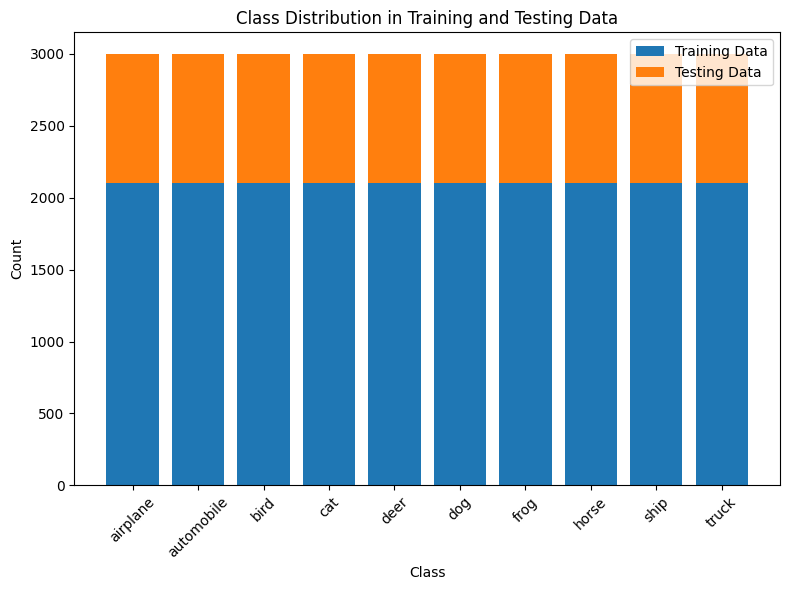

In [5]:
# Plot the distribution of classes in training and testing data
import matplotlib.pyplot as plt
import numpy as np

# Count the occurrences of each class
train_class_counts = {}
test_class_counts = {}

# Get unique classes and their counts
for label in range(10):  # CIFAR-10 has 10 classes (0-9)
    train_class_counts[label] = (train_data.Y == label).sum()
    test_class_counts[label] = (test_data.Y == label).sum()

# Get class names from CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure for the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Prepare data for stacked bar chart
train_counts = list(train_class_counts.values())
test_counts = list(test_class_counts.values())

# Create the stacked bar chart
ax.bar(class_names, train_counts, label='Training Data')
ax.bar(class_names, test_counts, bottom=train_counts, label='Testing Data')

# Add labels and title
ax.set_title('Class Distribution in Training and Testing Data')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


### Phase 2: Building a Machine Learning Model
3.	Choose a machine learning model architecture (deep neural network, convolutional neural network…).
4.	Train on clean data with validation-based early stopping
5.	Establish baseline performance metrics (Accuracy and Confusion Matrix)

Using device: cuda
CNN Model Architecture:
CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)
Training the CNN model...
Training completed in 29.21 seconds
Test accuracy: 0.5926


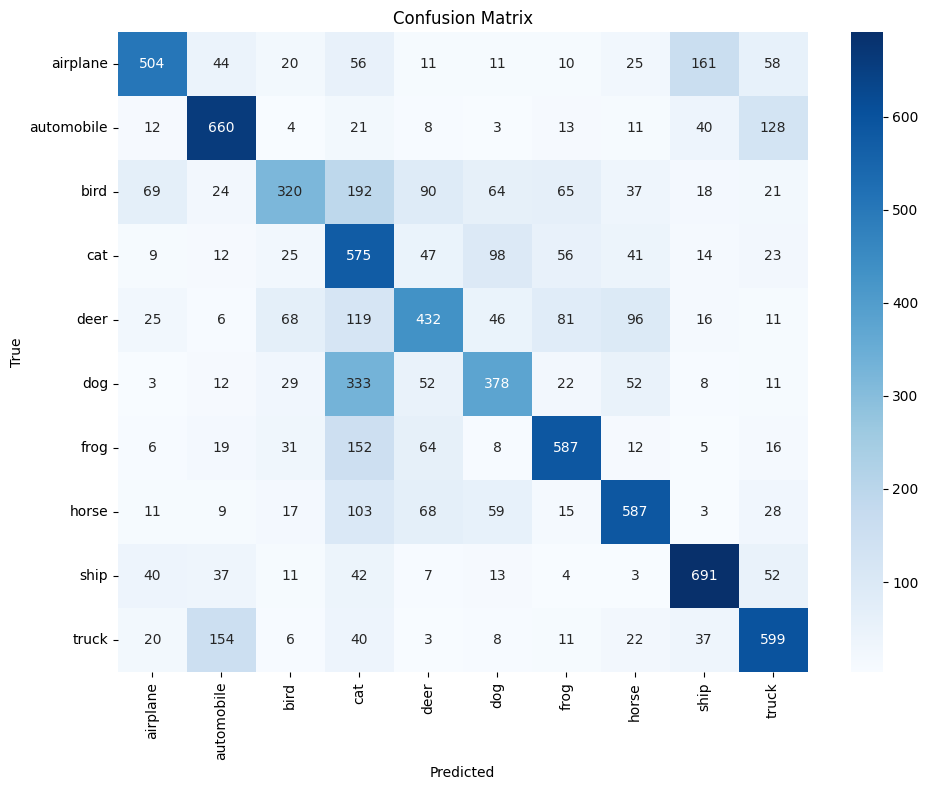

In [6]:
# Import necessary libraries for building and training a CNN model
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# Check if MPS is available (for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# Define a CNN model using PyTorch
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Reshape input from (n_samples, 3072) to (n_samples, 3, 32, 32)
        x = x.view(-1, 3, 32, 32)
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the appropriate device
model = CIFAR10CNN().to(device)
print("CNN Model Architecture:")
print(model)

# Define training parameters
learning_rate = 0.001
batch_size = 512
num_epochs = 10

# Create a SecML classifier from the PyTorch model
classifier = CClassifierPyTorch(model=model,
                               loss=nn.CrossEntropyLoss(),
                               optimizer=optim.Adam(model.parameters(), lr=learning_rate),
                               input_shape=(3, 32, 32),
                               preprocess=None,
                               epochs=num_epochs,
                               batch_size=batch_size)

# Start training timer
start_time = time.time()

# Train the model
print("Training the CNN model...")
classifier.fit(train_data.X, train_data.Y)

# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate on test data
y_pred = classifier.predict(test_data.X)
acc = CMetricAccuracy().performance_score(test_data.Y, y_pred)
print(f"Test accuracy: {acc:.4f}")

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions as numpy array
y_true = test_data.Y.tondarray()
y_pred = classifier.predict(test_data.X).tondarray()

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### Phase 3: Training-Time Attacks (Data Poisoning)

#### 6.	 Poisoning Attack Implementation
- Inject malicious samples into training data using one of:
- Label-flipping attacks
- Any of the clean-label backdoor attacks
- maintain attack budget (<15% training data contamination)


In [7]:
# Implement a label flipping poisoning attack
print("Implementing label flipping poisoning attack...")

# Define the attack budget (15% of training data)
attack_budget = int(0.15 * (train_data.X.shape[0]))
print(f"Attack budget: {attack_budget} samples (15% of training data)")

# Create a copy of the training data
poisoned_X = train_data.X.deepcopy()
poisoned_Y = train_data.Y.deepcopy()

# Randomly select indices to poison
np.random.seed(42)  # For reproducibility
indices_to_poison = np.random.choice(train_data.X.shape[0], attack_budget, replace=False)

# Flip the labels of the selected samples
# For CIFAR-10, we'll flip each label to a different class
for idx in indices_to_poison:
    original_label = poisoned_Y[idx].item()
    # Choose a random label different from the original
    new_label = np.random.choice([l for l in range(10) if l != original_label])
    poisoned_Y[idx] = new_label

print(f"Poisoned {attack_budget} samples with label flipping")

# Create a validation set from the poisoned samples to evaluate attack success
poisoned_validation_X = poisoned_X.get_data()[indices_to_poison]
poisoned_validation_Y = poisoned_Y.get_data()[indices_to_poison]
original_validation_Y = train_data.Y.get_data()[indices_to_poison]

# Display some statistics about the poisoning
label_changes = {}
for i in range(len(indices_to_poison)):
    original = original_validation_Y[i].item()
    flipped = poisoned_validation_Y[i].item()
    key = f"{original} → {flipped}"
    label_changes[key] = label_changes.get(key, 0) + 1

print("\nLabel flipping statistics:")
for change, count in sorted(label_changes.items()):
    print(f"  {change}: {count} samples")

# Save the poisoned dataset for the next phase
poisoned_train_data = CDataset(poisoned_X, poisoned_Y)


Implementing label flipping poisoning attack...
Attack budget: 3150 samples (15% of training data)
Poisoned 3150 samples with label flipping

Label flipping statistics:
  0 → 1: 34 samples
  0 → 2: 32 samples
  0 → 3: 36 samples
  0 → 4: 44 samples
  0 → 5: 28 samples
  0 → 6: 34 samples
  0 → 7: 25 samples
  0 → 8: 35 samples
  0 → 9: 34 samples
  1 → 0: 31 samples
  1 → 2: 41 samples
  1 → 3: 33 samples
  1 → 4: 33 samples
  1 → 5: 41 samples
  1 → 6: 39 samples
  1 → 7: 35 samples
  1 → 8: 40 samples
  1 → 9: 27 samples
  2 → 0: 25 samples
  2 → 1: 43 samples
  2 → 3: 27 samples
  2 → 4: 38 samples
  2 → 5: 26 samples
  2 → 6: 39 samples
  2 → 7: 30 samples
  2 → 8: 33 samples
  2 → 9: 45 samples
  3 → 0: 47 samples
  3 → 1: 37 samples
  3 → 2: 25 samples
  3 → 4: 27 samples
  3 → 5: 29 samples
  3 → 6: 41 samples
  3 → 7: 44 samples
  3 → 8: 38 samples
  3 → 9: 27 samples
  4 → 0: 45 samples
  4 → 1: 29 samples
  4 → 2: 38 samples
  4 → 3: 43 samples
  4 → 5: 26 samples
  4 → 6: 30

#### 7.	Poisoned Model Evaluation
- Retrain model on contaminated dataset
- Compare performance degradation on:
   - Clean test set
   - Poisoned validation samples
   - Original validation set


CNN Model Architecture:
CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)
Training the CNN model...
Training completed in 28.91 seconds
Test accuracy: 0.5714


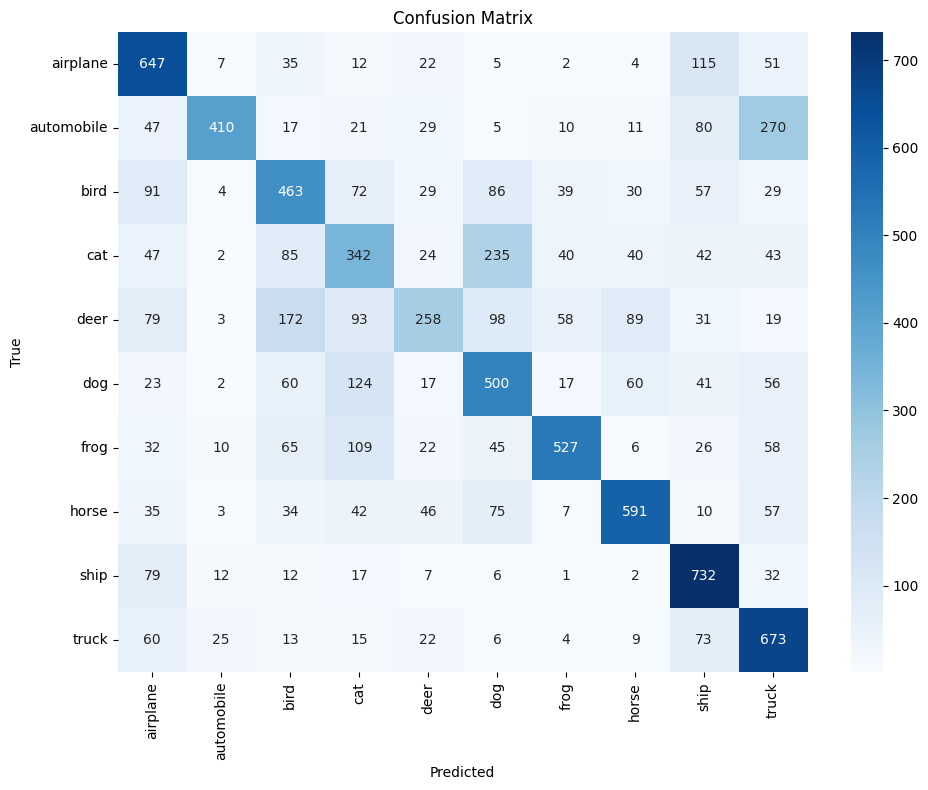

In [8]:
poisoned_model = CIFAR10CNN().to(device)
print("CNN Model Architecture:")
print(poisoned_model)

# Define training parameters
learning_rate = 0.001
batch_size = 128
num_epochs = 10

# Create a SecML classifier from the PyTorch model
poisoned_classifier = CClassifierPyTorch(model=poisoned_model,
                               loss=nn.CrossEntropyLoss(),
                               optimizer=optim.Adam(poisoned_model.parameters(), lr=learning_rate),
                               input_shape=(3, 32, 32),
                               preprocess=None,
                               epochs=num_epochs,
                               batch_size=batch_size)

# Start training timer
start_time = time.time()

# Train the model
print("Training the CNN model...")
poisoned_classifier.fit(poisoned_train_data.X, poisoned_train_data.Y)

# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate on test data
y_pred = poisoned_classifier.predict(test_data.X)
acc = CMetricAccuracy().performance_score(test_data.Y, y_pred)
print(f"Test accuracy: {acc:.4f}")

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions as numpy array
y_true = test_data.Y.tondarray()
y_pred = poisoned_classifier.predict(test_data.X).tondarray()

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Phase 4: Inference-Time Attacks (Adversarial Examples)
#### 8.	Adversarial Attack Generation
- Implement two distinct attack methods:
  - White-box: FGSM/PGD/C&W/DeepFool
  - Black-box: Surrogate model
- Generate adversarial test sets with controlled perturbation budgets (ε ≤ 0.1)


In [33]:
# Implement PGD (Projected Gradient Descent) attack
from secml.adv.attacks import CAttackEvasionPGD
from secml.array import CArray
from secml.figure import CFigure

print("Implementing PGD (Projected Gradient Descent) attack...")

# Define attack parameters
epsilon = 0.1  # Maximum perturbation budget
lb, ub = 0.0, 1.0  # Lower and upper bounds for the features
y_target = None  # None for untargeted attack

# Select a subset of test samples to attack (for demonstration)
n_samples = 10
indices = np.random.choice(test_data.X.shape[0], n_samples, replace=False)
x_test_subset = test_data.X.get_data()[indices, :]
y_test_subset = test_data.Y.get_data()[indices]

# Generate adversarial examples
print(f"Generating adversarial examples using PGD attack (epsilon={epsilon})...")
adv_examples = []
original_predictions = []
adversarial_predictions = []

for i in range(n_samples):
    print(f"Processing sample {i+1}/{n_samples}...")
    
    # Create a new PGD attack instance for each sample
    pgd_attack = CAttackEvasionPGD(
        classifier=poisoned_classifier,
        double_init_ds=test_data,
        distance='l2',
        dmax=epsilon,
        lb=lb, ub=ub,
        y_target=None  # Untargeted attack
    )
    
    # Get the current sample
    x_i = x_test_subset[i, :]
    y_i = y_test_subset[i]
    
    # Run the attack directly on the sample
    _, _, adv_x, _ = pgd_attack.run(x_i, y_i)
    # Store results
    adv_examples.append(adv_x.X)
    original_predictions.append(poisoned_classifier.predict(x_i))
    adversarial_predictions.append(poisoned_classifier.predict(adv_x.X))

# Convert to CArray
# Convert list to CArray first, then concatenate
adv_examples = CArray(adv_examples)
original_predictions = CArray(original_predictions)
adversarial_predictions = CArray(adversarial_predictions)

# Calculate attack success rate
attack_success = (original_predictions != adversarial_predictions).mean()
print(f"Attack success rate: {attack_success:.4f}")

# Visualize some examples
n_to_plot = min(5, n_samples)
fig = CFigure(width=10, height=8)
for i in range(n_to_plot):
    fig.subplot(n_to_plot, 2, 2*i+1)
    fig.sp.title(f"Original: {class_names[int(original_predictions[i].item())]}")
    fig.sp.imshow(x_test_subset[i, :].reshape(28, 28), cmap='gray')
    
    fig.subplot(n_to_plot, 2, 2*i+2)
    fig.sp.title(f"Adversarial: {class_names[int(adversarial_predictions[i].item())]}")
    fig.sp.imshow(adv_examples[i, :].reshape(28, 28), cmap='gray')

fig.tight_layout()
fig.show()


Implementing PGD (Projected Gradient Descent) attack...
Generating adversarial examples using PGD attack (epsilon=0.1)...
Processing sample 1/10...
Processing sample 2/10...
Processing sample 3/10...
Processing sample 4/10...
Processing sample 5/10...
Processing sample 6/10...
Processing sample 7/10...
Processing sample 8/10...
Processing sample 9/10...
Processing sample 10/10...


TypeError: Array is malformed, check input data.

#### 9.	Attack Impact Analysis
- Quantify robustness drop using:
  - Adversarial success rate
  - Confidence score distributions
  - Per-class vulnerability analysis


### Phase 5: Comprehensive Evaluation
#### 10.	Cross-Attack Susceptibility
- Test poisoned model against unseen attack vectors
- Analyze transferability between attack methods


#### 11.	Vulnerability Report
- Create visualization: Security Curve for accuracy with both perturbations number and number of poisoned samples.
- Document failure modes and high-risk decision boundaries


# Part 2:  Defending Against Data Poisoning and Adversarial Attacks in Machine Learning

## -Part 2 Phases:
### Phase 1: Poisoning Defense Implementation
#### 1.	Choose one Data Sanitization Techniques for example: 
- Implement anomaly detection (Isolation Forest/MAD)
- Apply spectral signature analysis for poisoned sample removal
#### 2.	And one method of Robust Training Methods for example:
- Integrate regularization (Dropout/Weight Clipping)
- Explore differentially private training


### Phase 2: Adversarial Defense Strategies
#### 3.	Input Preprocessing Defenses
- Test randomized smoothing techniques
#### 4.	Model Hardening
- Apply adversarial training with PGD examples
- Explore certified robustness methods (IBP/RS-Certify)


### Phase 3: Defense Evaluation
#### 5.	Quantitative Analysis
- Compare metrics before/after defenses:
  - Clean data accuracy preservation
  - Attack success rate reduction
  - Computational overhead
#### 6.	Qualitative Analysis
- Visualize decision boundary changes
- Conduct gradient sensitivity analysis


### Phase 4: Reporting & Advanced Exploration
#### 7.	Documentation Requirements
- Technical report (5-10 pages) covering:
  - Threat models & attack mechanics
  - Defense implementation details
  - Statistical evidence for robustness claims
